# Strong Scaling of ML Training on CPU and GPU of Aurora

In [1]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [2]:
class Performance:
    def __init__(self,path):
        self.base_path = path

    def get_sim_runtime(self,string):
        return string.split(":")[1].strip()
    
    def get_sim_sr_time(self,string,keyword):
        tmp = string.strip(keyword).lstrip()
        return list(map(float,tmp.split()))[2]
    
    def get_ml_time(self,string):
        tmp = string.split(":")[1].strip()
        tmp = tmp.split(",")[1]
        return float(tmp.split("=")[1].strip())
    
    def get_tp_sum(self,string):
        tmp = string.split(":")[1].strip()
        tmp = tmp.split(",")[-1]
        return float(tmp.split("=")[1].strip())

    def parse_files(self):
        path = self.base_path+'/cfdml/'
        run_dirs = glob.glob(path+'/*/')
        num_dirs = len(run_dirs)
        
        # Initialize arrays
        self.sim_runtime = np.zeros((num_dirs,))
        self.sim_steps = np.zeros((num_dirs,))
        self.sim_sr_init = np.zeros((num_dirs,))
        self.sim_sr_meta = np.zeros((num_dirs,))
        self.sim_sr_train = np.zeros((num_dirs,))
        self.sim_sr_sum = np.zeros((num_dirs,))
        self.sim_sr_oh = np.zeros((num_dirs,))
        self.ml_runtime = np.zeros((num_dirs,))
        self.ml_sr_init = np.zeros((num_dirs,))
        self.ml_sr_meta = np.zeros((num_dirs,))
        self.ml_sr_train = np.zeros((num_dirs,))
        self.ml_sr_sum = np.zeros((num_dirs,))
        self.ml_sr_oh = np.zeros((num_dirs,))
        self.ml_train = np.zeros((num_dirs,))
        self.ml_tp = np.zeros((num_dirs,))
        
        # Loop over runs found
        i = 0
        for run_dir in run_dirs:
            print('Reading case directory: ', run_dir)
            
            # Simulation file
            with open(run_dir+'sim/sim.out','r') as fh:
                for l in fh:
                    if "Time taken for solution (sec):" in l:
                        self.sim_runtime[i] = self.get_sim_runtime(l)
                    if "SmartRedis_Init" in l:
                        self.sim_sr_init[i] = self.get_sim_sr_time(l,"SmartRedis_Init")
                    if "SmartRedis_Meta" in l:
                        self.sim_sr_meta[i] += self.get_sim_sr_time(l,"SmartRedis_Meta")
                    if "SmartRedis_Train" in l:
                        self.sim_sr_train[i] = self.get_sim_sr_time(l,"SmartRedis_Train")
                self.sim_sr_sum[i] = self.sim_sr_init[i]+self.sim_sr_meta[i]+self.sim_sr_train[i]
                self.sim_sr_oh[i] = self.sim_sr_sum[i]/self.sim_runtime[i]
    
            # Training file
            with open(run_dir+'/train/train.out','r') as fh:
                for l in fh:
                    if "Total training time" in l:
                        self.ml_runtime[i] = self.get_ml_time(l)
                    if "SmartRedis client initialization" in l:
                        self.ml_sr_init[i] = self.get_ml_time(l)
                    if "SmartRedis metadata transfer" in l:
                        self.ml_sr_meta[i] = self.get_ml_time(l)
                    if "SmartRedis training batch data transfer" in l:
                        self.ml_sr_train[i] = self.get_ml_time(l)
                    if "Total time spent in training loop" in l:
                        self.ml_train[i] = self.get_ml_time(l)
                    if "Total training throughput" in l:
                        self.ml_tp[i] = self.get_tp_sum(l)
                self.ml_sr_sum[i] = self.ml_sr_init[i]+self.ml_sr_meta[i]+self.ml_sr_train[i]
                self.ml_sr_oh[i] = self.ml_sr_sum[i]/self.ml_runtime[i]
            
            i+=1

In [3]:
## 12 tiles used for simulation, with binding "list:1:8:16:24:32:40:53:60:68:76:84:92"
## DB on last 4 cores of socket 0:  [48,49,50,51]
## ML training on CPU with increasing ranks, and CPU binding staggered by 4 from simulation

top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong"

## 1 ML rank
path = top_dir+"/1"
ss1_cpu = Performance(path)
ss1_cpu.parse_files()

## 2 ML rank
path = top_dir+"/2"
ss2_cpu = Performance(path)
ss2_cpu.parse_files()

## 4 ML rank
path = top_dir+"/4"
ss4_cpu = Performance(path)
ss4_cpu.parse_files()

## 6 ML rank, 3 on each socket
path = top_dir+"/6"
ss6_cpu = Performance(path)
ss6_cpu.parse_files()

## 6 ML rank, all on socket 0
path = top_dir+"/6b"
ss6b_cpu = Performance(path)
ss6b_cpu.parse_files()

## 12 ML rank
path = top_dir+"/12"
ss12_cpu = Performance(path)
ss12_cpu.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/1/cfdml/21-08-2024_18-58-59/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/2/cfdml/21-08-2024_18-37-56/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/4/cfdml/21-08-2024_22-20-53/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/6/cfdml/21-08-2024_18-25-55/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/6b/cfdml/21-08-2024_21-57-05/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/6b/cfdml/21-08-2024_22-12-49/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong/6b/cfdml/21-08-2024

In [4]:
## 10 tiles used for simulation, with binding "list:1:8:16:24:32:40:53:60:68:76"
## DB on last 4 cores of socket 0:  [48,49,50,51]
## ML training on GPU with increasing ranks, and CPU binding 84:92, using CCS for 4 ranks on 2 tiles

top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_gpu_scaling/strong"

## 1 ML rank
path = top_dir+"/1"
ss1_gpu = Performance(path)
ss1_gpu.parse_files()

## 2 ML rank
path = top_dir+"/2"
ss2_gpu = Performance(path)
ss2_gpu.parse_files()

## 4 ML rank
path = top_dir+"/4"
ss4_gpu = Performance(path)
ss4_gpu.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_gpu_scaling/strong/1/cfdml/22-08-2024_15-55-34/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_gpu_scaling/strong/1/cfdml/21-08-2024_23-05-34/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_gpu_scaling/strong/2/cfdml/21-08-2024_23-01-02/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_gpu_scaling/strong/4/cfdml/22-08-2024_16-00-14/


In [5]:
## 12 tiles used for simulation, with binding "list:1:8:16:24:32:40:53:60:68:76:84:92"
## DB on last 4 cores of socket 0:  [48,49,50,51]
## ML training on CPU with increasing ranks and 2 threads, and CPU binding staggered by 4 from simulation

top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads"

## 1 ML rank
path = top_dir+"/1"
ss1_2_cpu = Performance(path)
ss1_2_cpu.parse_files()

## 2 ML rank
path = top_dir+"/2"
ss2_2_cpu = Performance(path)
ss2_2_cpu.parse_files()

## 4 ML rank
path = top_dir+"/4"
ss4_2_cpu = Performance(path)
ss4_2_cpu.parse_files()

## 6 ML rank, 3 on each socket
path = top_dir+"/6"
ss6_2_cpu = Performance(path)
ss6_2_cpu.parse_files()

## 12 ML rank
path = top_dir+"/12"
ss12_2_cpu = Performance(path)
ss12_2_cpu.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads/1/cfdml/27-08-2024_23-04-58/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads/2/cfdml/27-08-2024_22-54-59/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads/4/cfdml/27-08-2024_22-51-00/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads/6/cfdml/27-08-2024_22-49-24/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_2threads/12/cfdml/27-08-2024_22-48-47/


In [6]:
## 12 tiles used for simulation, with binding "list:1:8:16:24:32:40:53:60:68:76:84:92"
## DB on last 4 cores of socket 0:  [48,49,50,51]
## ML training on CPU with increasing ranks and 4 threads, and CPU binding staggered by 4 from simulation

top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads"

## 1 ML rank
path = top_dir+"/1"
ss1_4_cpu = Performance(path)
ss1_4_cpu.parse_files()

## 2 ML rank
path = top_dir+"/2"
ss2_4_cpu = Performance(path)
ss2_4_cpu.parse_files()

## 4 ML rank
path = top_dir+"/4"
ss4_4_cpu = Performance(path)
ss4_4_cpu.parse_files()

## 6 ML rank, 3 on each socket
path = top_dir+"/6"
ss6_4_cpu = Performance(path)
ss6_4_cpu.parse_files()

## 12 ML rank
path = top_dir+"/12"
ss12_4_cpu = Performance(path)
ss12_4_cpu.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads/1/cfdml/27-08-2024_23-03-33/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads/2/cfdml/27-08-2024_22-59-12/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads/4/cfdml/27-08-2024_22-55-31/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads/6/cfdml/27-08-2024_22-55-07/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_4threads/12/cfdml/27-08-2024_22-55-31/


In [8]:
## 12 tiles used for simulation, with binding "list:1:8:16:24:32:40:53:60:68:76:84:92"
## DB on last 4 cores of socket 0:  [48,49,50,51]
## ML training on CPU with increasing ranks and 8 threads, and CPU binding staggered by 4 from simulation using hyperthreads

top_dir = "/Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads"

## 1 ML rank
path = top_dir+"/1"
ss1_8_cpu = Performance(path)
ss1_8_cpu.parse_files()

## 2 ML rank
path = top_dir+"/2"
ss2_8_cpu = Performance(path)
ss2_8_cpu.parse_files()

## 4 ML rank
path = top_dir+"/4"
ss4_8_cpu = Performance(path)
ss4_8_cpu.parse_files()

## 6 ML rank, 3 on each socket
path = top_dir+"/6"
ss6_8_cpu = Performance(path)
ss6_8_cpu.parse_files()

## 12 ML rank
path = top_dir+"/12"
ss12_8_cpu = Performance(path)
ss12_8_cpu.parse_files()

Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads/1/cfdml/16-09-2024_20-13-48/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads/2/cfdml/16-09-2024_20-06-52/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads/4/cfdml/16-09-2024_20-02-18/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads/6/cfdml/16-09-2024_20-11-35/
Reading case directory:  /Users/rbalin/Documents/Research/ALCF/CFDML/libCEED/1_node_tests/ml_on_cpu_scaling/strong_8threads/12/cfdml/16-09-2024_20-17-39/


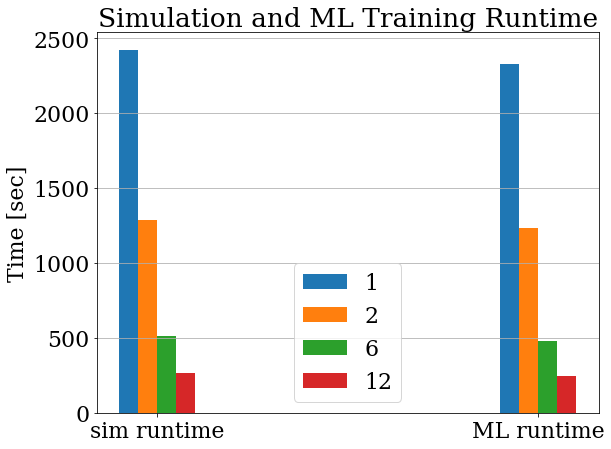

In [9]:
# Plot results
labels = ['sim runtime', 'ML runtime']
x = np.arange(len(labels))  # the label locations
width = 0.05  # the width of the bars
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))

axs.bar(x-1.5*width, [np.mean(ss1.sim_runtime), np.mean(ss1.ml_runtime)], width, 
                  yerr=[np.std(ss1.sim_runtime), np.std(ss1.ml_runtime)],label='1')
axs.bar(x-0.5*width, [np.mean(ss2.sim_runtime), np.mean(ss2.ml_runtime)], width, 
                  yerr=[np.std(ss2.sim_runtime), np.std(ss2.ml_runtime)],label='2')
axs.bar(x+0.5*width, [np.mean(ss6.sim_runtime), np.mean(ss6.ml_runtime)], width, 
                  yerr=[np.std(ss6.sim_runtime), np.std(ss6.ml_runtime)],label='6')
axs.bar(x+1.5*width, [np.mean(ss12.sim_runtime), np.mean(ss12.ml_runtime)], width, 
                  yerr=[np.std(ss12.sim_runtime), np.std(ss12.ml_runtime)],label='12')
axs.set_ylabel('Time [sec]')
axs.set_title('Simulation and ML Training Runtime')
axs.set_xticks(x);axs.set_xticklabels(labels)
#axs.set_xticks(x, labels)
axs.legend()
axs.grid(axis='y')

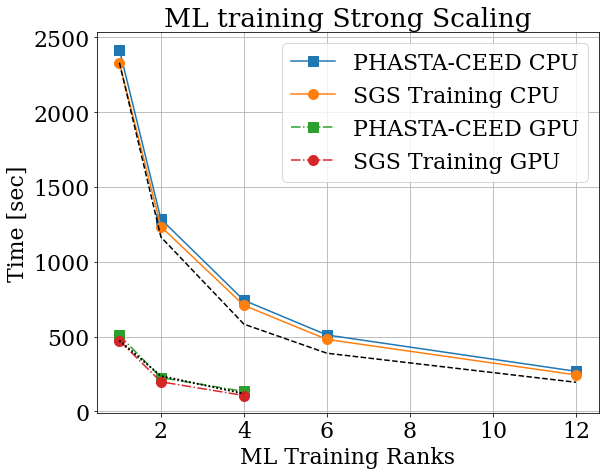

In [64]:
# Plot results
ml_ranks_cpu = [1,2,4,6,12]
ml_ranks_gpu = [1,2,4]

sim_runtime_cpu = [np.mean(ss1_cpu.sim_runtime),np.mean(ss2_cpu.sim_runtime),np.mean(ss4_cpu.sim_runtime),np.mean(ss6_cpu.sim_runtime),np.mean(ss12_cpu.sim_runtime)]
ml_runtime_cpu = [np.mean(ss1_cpu.ml_runtime),np.mean(ss2_cpu.ml_runtime),np.mean(ss4_cpu.ml_runtime),np.mean(ss6_cpu.ml_runtime),np.mean(ss12_cpu.ml_runtime)]
ml_runtime2 = [np.mean(ss1_cpu.ml_runtime),np.mean(ss2_cpu.ml_runtime),np.mean(ss6b_cpu.ml_runtime),np.mean(ss12_cpu.ml_runtime)]
#ml_train = [np.mean(ss1.ml_train),np.mean(ss2.ml_train),np.mean(ss6.ml_train),np.mean(ss12.ml_train)]
ideal_cpu = [ss1_cpu.ml_runtime, ss1_cpu.ml_runtime/2, ss1_cpu.ml_runtime/4, ss1_cpu.ml_runtime/6, ss1_cpu.ml_runtime/12]

sim_runtime_gpu = [np.mean(ss1_gpu.sim_runtime),np.mean(ss2_gpu.sim_runtime),np.mean(ss4_gpu.sim_runtime)]
ml_runtime_gpu = [np.mean(ss1_gpu.ml_runtime),np.mean(ss2_gpu.ml_runtime),np.mean(ss4_gpu.ml_runtime)]
ideal_gpu = [ss1_gpu.ml_runtime, ss1_gpu.ml_runtime/2, ss1_gpu.ml_runtime/4]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
axs.plot(ml_ranks_cpu, sim_runtime_cpu,label = "PHASTA-CEED CPU",marker="s",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ml_runtime_cpu,label = "SGS Training CPU",marker="o",ls="-",markersize=10)
#axs.plot(ml_ranks, ml_runtime2,label = "SGS Training",marker="o",ls="-",markersize=10)
#axs.plot(ml_ranks, ml_train,label = "SGS Training",marker="d",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_gpu, sim_runtime_gpu,label = "PHASTA-CEED GPU",marker="s",ls="-.",markersize=10)
axs.plot(ml_ranks_gpu, ml_runtime_gpu,label = "SGS Training GPU",marker="o",ls="-.",markersize=10)
axs.plot(ml_ranks_gpu, ideal_gpu,label = "",ls=":",markersize=10,color='k')

axs.set_ylabel('Time [sec]')
axs.set_xlabel('ML Training Ranks')
axs.set_title('ML training Strong Scaling')
axs.legend()
axs.grid()
#axs.set_yscale('log'); axs.set_xscale('log')


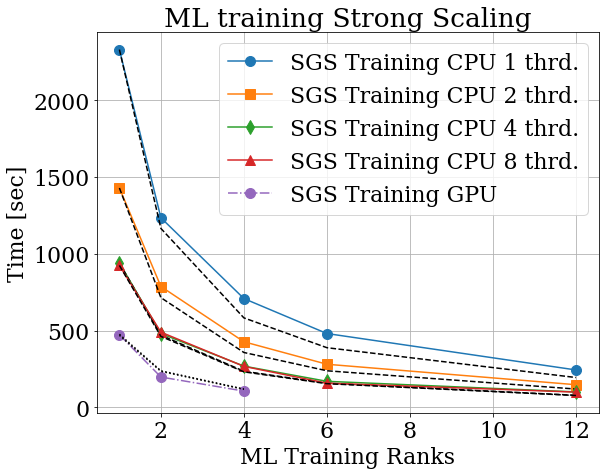

In [9]:
# Plot results
ml_ranks_cpu = [1,2,4,6,12]
ml_ranks_gpu = [1,2,4]

ml_runtime_cpu = [np.mean(ss1_cpu.ml_runtime),np.mean(ss2_cpu.ml_runtime),np.mean(ss4_cpu.ml_runtime),np.mean(ss6_cpu.ml_runtime),np.mean(ss12_cpu.ml_runtime)]
ideal_cpu = [ss1_cpu.ml_runtime, ss1_cpu.ml_runtime/2, ss1_cpu.ml_runtime/4, ss1_cpu.ml_runtime/6, ss1_cpu.ml_runtime/12]

ml_runtime_cpu_2 = [np.mean(ss1_2_cpu.ml_runtime),np.mean(ss2_2_cpu.ml_runtime),np.mean(ss4_2_cpu.ml_runtime),np.mean(ss6_2_cpu.ml_runtime),np.mean(ss12_2_cpu.ml_runtime)]
ideal_cpu_2 = [ss1_2_cpu.ml_runtime, ss1_2_cpu.ml_runtime/2, ss1_2_cpu.ml_runtime/4, ss1_2_cpu.ml_runtime/6, ss1_2_cpu.ml_runtime/12]

ml_runtime_cpu_4 = [np.mean(ss1_4_cpu.ml_runtime),np.mean(ss2_4_cpu.ml_runtime),np.mean(ss4_4_cpu.ml_runtime),np.mean(ss6_4_cpu.ml_runtime),np.mean(ss12_4_cpu.ml_runtime)]
ideal_cpu_4 = [ss1_4_cpu.ml_runtime, ss1_4_cpu.ml_runtime/2, ss1_4_cpu.ml_runtime/4, ss1_4_cpu.ml_runtime/6, ss1_4_cpu.ml_runtime/12]

ml_runtime_cpu_8 = [np.mean(ss1_8_cpu.ml_runtime),np.mean(ss2_8_cpu.ml_runtime),np.mean(ss4_8_cpu.ml_runtime),np.mean(ss6_8_cpu.ml_runtime),np.mean(ss12_8_cpu.ml_runtime)]
ideal_cpu_8 = [ss1_8_cpu.ml_runtime, ss1_8_cpu.ml_runtime/2, ss1_8_cpu.ml_runtime/4, ss1_8_cpu.ml_runtime/6, ss1_8_cpu.ml_runtime/12]

ml_runtime_gpu = [np.mean(ss1_gpu.ml_runtime),np.mean(ss2_gpu.ml_runtime),np.mean(ss4_gpu.ml_runtime)]
ideal_gpu = [ss1_gpu.ml_runtime, ss1_gpu.ml_runtime/2, ss1_gpu.ml_runtime/4]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
axs.plot(ml_ranks_cpu, ml_runtime_cpu,label = "SGS Training CPU 1 thrd.",marker="o",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_cpu, ml_runtime_cpu_2,label = "SGS Training CPU 2 thrd.",marker="s",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu_2,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_cpu, ml_runtime_cpu_4,label = "SGS Training CPU 4 thrd.",marker="d",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu_4,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_cpu, ml_runtime_cpu_8,label = "SGS Training CPU 8 thrd.",marker="^",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu_8,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_gpu, ml_runtime_gpu,label = "SGS Training GPU",marker="o",ls="-.",markersize=10)
axs.plot(ml_ranks_gpu, ideal_gpu,label = "",ls=":",markersize=10,color='k')

axs.set_ylabel('Time [sec]')
axs.set_xlabel('ML Training Ranks')
axs.set_title('ML training Strong Scaling')
axs.legend()
axs.grid()
#axs.set_yscale('log'); axs.set_xscale('log')


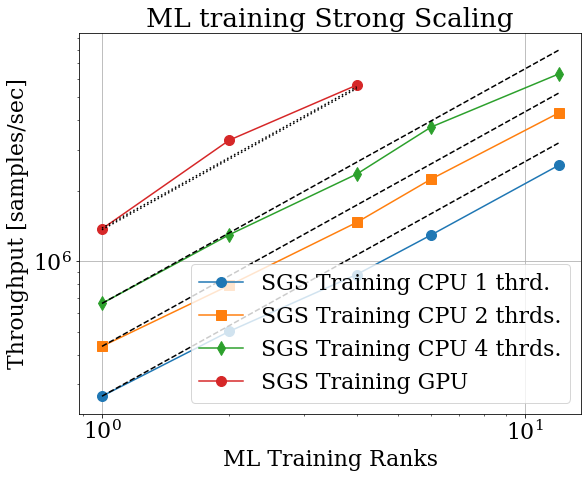

In [9]:
# Plot results
ml_ranks_cpu = [1,2,4,6,12]
ml_ranks_gpu = [1,2,4]

ml_tp_cpu = [np.mean(ss1_cpu.ml_tp),np.mean(ss2_cpu.ml_tp),np.mean(ss4_cpu.ml_tp),np.mean(ss6_cpu.ml_tp),np.mean(ss12_cpu.ml_tp)]
ideal_cpu = [ss1_cpu.ml_tp, ss1_cpu.ml_tp*2, ss1_cpu.ml_tp*4, ss1_cpu.ml_tp*6, ss1_cpu.ml_tp*12]
#ideal = [ss2.ml_tp, ss2.ml_tp*3, ss2.ml_tp*6]

ml_tp_cpu_2 = [np.mean(ss1_2_cpu.ml_tp),np.mean(ss2_2_cpu.ml_tp),np.mean(ss4_2_cpu.ml_tp),np.mean(ss6_2_cpu.ml_tp),np.mean(ss12_2_cpu.ml_tp)]
ideal_cpu_2 = [ss1_2_cpu.ml_tp, ss1_2_cpu.ml_tp*2, ss1_2_cpu.ml_tp*4, ss1_2_cpu.ml_tp*6, ss1_2_cpu.ml_tp*12]

ml_tp_cpu_4 = [np.mean(ss1_4_cpu.ml_tp),np.mean(ss2_4_cpu.ml_tp),np.mean(ss4_4_cpu.ml_tp),np.mean(ss6_4_cpu.ml_tp),np.mean(ss12_4_cpu.ml_tp)]
ideal_cpu_4 = [ss1_4_cpu.ml_tp, ss1_4_cpu.ml_tp*2, ss1_4_cpu.ml_tp*4, ss1_4_cpu.ml_tp*6, ss1_4_cpu.ml_tp*12]

ml_tp_gpu = [np.mean(ss1_gpu.ml_tp),np.mean(ss2_gpu.ml_tp),np.mean(ss4_gpu.ml_tp)]
ideal_gpu = [ss1_gpu.ml_tp, ss1_gpu.ml_tp*2, ss1_gpu.ml_tp*4]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
axs.plot(ml_ranks_cpu, ml_tp_cpu,label = "SGS Training CPU 1 thrd.",marker="o",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_cpu, ml_tp_cpu_2,label = "SGS Training CPU 2 thrds.",marker="s",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu_2,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_cpu, ml_tp_cpu_4,label = "SGS Training CPU 4 thrds.",marker="d",ls="-",markersize=10)
axs.plot(ml_ranks_cpu, ideal_cpu_4,label = "",ls="--",markersize=10,color='k')

axs.plot(ml_ranks_gpu, ml_tp_gpu,label = "SGS Training GPU",marker="o",ls="-",markersize=10)
axs.plot(ml_ranks_gpu, ideal_gpu,label = "",ls=":",markersize=10,color='k')

axs.set_ylabel('Throughput [samples/sec]')
axs.set_xlabel('ML Training Ranks')
axs.set_title('ML training Strong Scaling')
axs.legend()
axs.grid()
axs.set_yscale('log'); axs.set_xscale('log')
